#### take significant parcels from OSS ISC-emotion correlation to select voxels for Toy Story in order to run the same analysis

In [1]:
import os
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed
import cProfile
import time
from glob import glob
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import RidgeCV
from isc_standalone import p_from_null
from ISC_Helper import get_rois, _compute_phaseshift_sliding_isc, load_roi_data, parcellate_bold, load_schaeffer1000, parcel_to_nifti
from statsmodels.stats.multitest import multipletests
import nibabel as nib
# %matplotlib inline

/usr/people/ri4541/miniconda3/envs/isc2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load OSS data
betas = nib.load('/usr/people/ri4541/juke/isc/data/emotion_betas_corrected.nii')
pvals = nib.load('/usr/people/ri4541/juke/isc/data/emotion_pvals_corrected.nii')

In [3]:
task = 'toystory'
# roi_selected = ['visualcortex', 'auditory', 'vmPFC', 'ACC', 'PCC', 'insula', 'amygdala', 'NA']
roi_selected = ['wholebrain']
# emotions = ['P', 'N', 'M', 'X', 'Cry']  # Positive, Negative, Mixed, Neutral, Cry
emotions = ['P', 'N', 'M']
parcellate = True
avg_over_roi = False
spatial = False
pairwise = False
random_state = None
window_size = 30
step_size = 5

if task == 'toystory':
    n_trs = 288
    n_shifts = 102400
elif task == 'onesmallstep':
    n_trs = 454
    n_shifts = 1024
else:
    raise Exception('task not defined')
n_windows = int((n_trs - window_size) / step_size) + 1

smooth = 'smooth'
avg_over_roi_name = "avg" if avg_over_roi else "voxelwise"
spatial_name = "spatial" if spatial else "temporal"
pairwise_name = "pairwise" if pairwise else "group"

# -------------------------------
# File paths
# -------------------------------
amb_aff_path = '/jukebox/norman/rsiyer/isc'
# amb_aff_path = '/Volumes/BCI-1/Ambivalent_Affect'
if task == 'toystory':
    data_dir_func = f'{amb_aff_path}/toystory/nuisance_regressed_cut'
elif task == 'onesmallstep':
    data_dir_func = f'{amb_aff_path}/fMRI_Study/ISC_Data_cut/NuisanceRegressed'
else:
    raise ValueError('Invalid task')
func_fns = glob(join(data_dir_func, 'P?.nii.gz')) + glob(join(data_dir_func, 'N?.nii.gz')) + \
           glob(join(data_dir_func, 'VR?.nii.gz')) + glob(join(data_dir_func, 'P??.nii.gz')) + \
           glob(join(data_dir_func, 'N??.nii.gz')) + glob(join(data_dir_func, 'VR??.nii.gz'))

if task == 'toystory':
    label_dir = f'{amb_aff_path}/VideoLabelling/Toy_Story_Labelled'
elif task == 'onesmallstep':
    label_dir = f'{amb_aff_path}/fMRI_Study/VideoLabelling/OSS_Labelled'

subj_ids = [str(subj).split('/')[-1].split('.')[0] for subj in func_fns]  # assume BIDS format
subj_ids.sort()

roi_mask_path = f'{amb_aff_path}/isc_scripts/rois'
all_roi_fpaths = glob(os.path.join(roi_mask_path, '*.nii*'))
all_roi_masker = get_rois(all_roi_fpaths)
data_path = f'{amb_aff_path}/outputs/{task}/data'
figure_path = f'{amb_aff_path}/outputs/{task}/figures'
parc_path = f"{amb_aff_path}/isc_scripts/schaefer_2018/Schaefer2018_1000Parcels_17Networks_order_FSLMNI152_2mm.nii.gz"
mask_path = f"{data_path}/mask_img.npy"

isc_path = f"{data_path}/isc_sliding_{pairwise_name}_n{len(subj_ids)}_{avg_over_roi_name}_roi{len(roi_selected)}_" \
           f"window{window_size}_step{step_size}.pkl"

sliding_perm_path = f"{data_path}/sliding_isc/permutations/phaseshift_size{window_size}_step{step_size}"
if parcellate:
    assert avg_over_roi is False
    sliding_perm_path += "parcellated"
    n_parcels = 1000
    parc, masked_parc = load_schaeffer1000(parc_path, mask_path)

In [4]:
# take significant voxels from betas
sig_betas = np.where(betas.get_fdata() != 0, 1, 0)

# check that they're the same as where pvals < 0.05
sig_pvals = np.where(pvals.get_fdata() < 0.05, 1, 0)
assert np.all(sig_betas == sig_pvals), "Betas and pvals don't match!"

AssertionError: Betas and pvals don't match!

In [ ]:
betas.get_fdata()

memmap([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0.

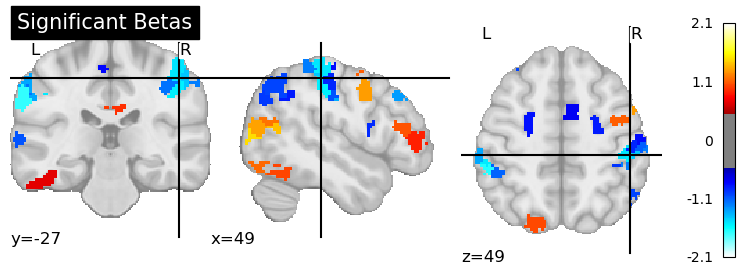

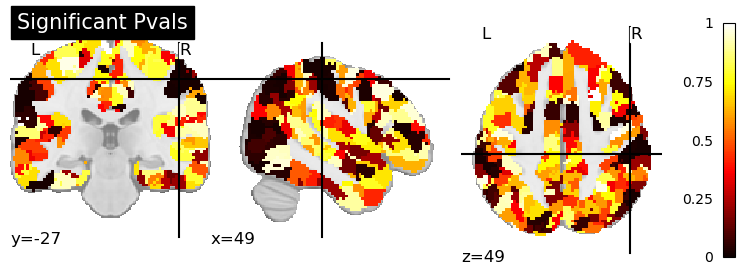

In [41]:
# plot significant voxels with plot_stat_map
from nilearn.plotting import plot_stat_map
plot_stat_map(betas.slicer[:,:,:,2], title='Significant Betas', threshold=0.5, colorbar=True)
plot_stat_map(pvals.slicer[:,:,:,2], title='Significant Pvals', threshold=0.0001, colorbar=True, cut_coords=(49, -27, 49))
plt.show()

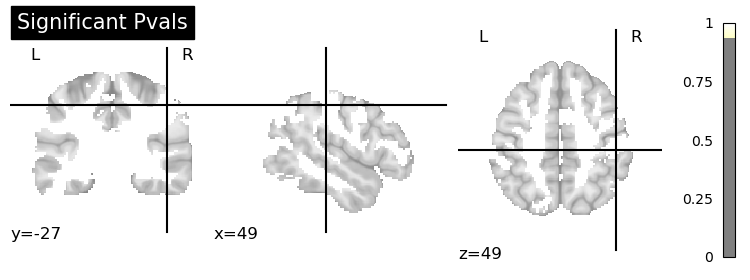

In [54]:
# reverse values in pvals.slicer[:,:,:,2] so i can threshold at 0.05
pvals_data = pvals.get_fdata()
pvals_data = np.where(pvals_data < 0.05, 1, 0)
# pvals_data = np.where(pvals_data == 1, 0, 1)
# pvals_data = np.where(pvals_data == 0, 0.05, 0)
pvals_img = nib.Nifti1Image(pvals_data, pvals.affine, pvals.header)
plot_stat_map(pvals_img.slicer[:,:,:,2], title='Significant Pvals', threshold=0.95, colorbar=True, cut_coords=(49, -27, 49))
plt.show()

In [6]:
mask_img = np.load(mask_path)
print(mask_img.shape)

(91, 109, 91)


In [7]:
# flatten and parcellate betas and pvals maps using masked_parc and parc
parcellated_betas = np.zeros((n_parcels, len(emotions)))
parcellated_pvals = np.zeros((n_parcels, len(emotions)))
# mask betas and pvals
masked_betas = betas.get_fdata()[mask_img != 0]
masked_pvals = pvals.get_fdata()[mask_img != 0]

In [11]:
betas.get_fdata().shape

(91, 109, 91, 3)

In [8]:
for parc in range(n_parcels):
    # get the indices of the parcels
    parcel_indices = np.where(masked_parc == parc)
    # print(f"Parcel {parc}: {len(parcel_indices[0])} voxels")
    # get the betas and pvals for the parcels
    parcellated_betas[parc, :] = np.mean(masked_betas[parcel_indices], axis=0)
    parcellated_pvals[parc, :] = np.mean(masked_pvals[parcel_indices], axis=0)

In [16]:
print(parcellated_betas.shape, parcellated_pvals.shape)
# print number of non-zero parcels
non_zero_parcels = np.sum(np.where(parcellated_betas != 0, 1, 0), axis=0)
print(f"Number of non-zero parcels (for each emotion): {non_zero_parcels}")

(1000, 3) (1000, 3)
Number of non-zero parcels (for each emotion): [101 124  89]


In [ ]:
# get indices of non-zero parcels in betas and pvals
non_zero_indices = np.where(parcellated_betas != 0)

non_zero_betas = parcellated_betas[non_zero_indices]
non_zero_pvals = parcellated_pvals[non_zero_indices]

In [42]:
np.where(parcellated_betas[:,0] != 0), np.where(parcellated_pvals[:,0] < 0.05)

((array([  1,   3,  13,  15,  18,  20,  21,  23,  24,  38,  67,  96,  98,
         109, 110, 132, 133, 139, 140, 141, 143, 144, 149, 155, 156, 178,
         184, 185, 188, 189, 194, 195, 205, 212, 215, 217, 226, 228, 249,
         258, 307, 308, 317, 319, 320, 337, 358, 364, 388, 501, 507, 514,
         515, 517, 519, 522, 523, 524, 526, 528, 569, 571, 576, 595, 656,
         662, 666, 669, 687, 688, 694, 695, 696, 697, 698, 699, 700, 730,
         740, 760, 777, 783, 826, 837, 849, 865, 866, 870, 875, 885, 898,
         919, 921, 925, 935, 943, 948, 957, 962, 972, 973]),),
 (array([  0,   1,   3,  13,  15,  18,  20,  21,  23,  24,  38,  67,  96,
          98, 109, 110, 132, 133, 139, 140, 141, 143, 144, 149, 155, 156,
         178, 184, 185, 188, 189, 194, 195, 205, 212, 215, 217, 226, 228,
         249, 258, 307, 308, 317, 319, 320, 337, 358, 364, 388, 501, 507,
         514, 515, 517, 519, 522, 523, 524, 526, 528, 569, 571, 576, 595,
         656, 662, 666, 669, 687, 688, 694, 695, 

In [50]:
for e in range(len(emotions)):
    print(f"Emotion {emotions[e]}")
    x = np.where(parcellated_betas[:,e] != 0)[0]
    y = np.where(parcellated_pvals[:,e] < 0.05)[0]
    c_x = 0
    for idx in range(len(x)):
        if idx not in y:
            # print(f"Parcel {x[idx]} is non-zero in betas but not significant in pvals")
            c_x += 1
    print(f"Number of parcels that are non-zero in betas but not significant in pvals: {c_x}")
    c_y = 0

    for idx in range(len(y)):
        if idx not in x:
            # print(f"Parcel {y[idx]} is significant in pvals but not non-zero in betas")
            c_y += 1
    print(f"Number of parcels that are significant in pvals but not non-zero in betas: {c_y}")

Emotion P
Number of parcels that are non-zero in betas but not significant in pvals: 87
Number of parcels that are significant in pvals but not non-zero in betas: 89
Emotion N
Number of parcels that are non-zero in betas but not significant in pvals: 109
Number of parcels that are significant in pvals but not non-zero in betas: 111
Emotion M
Number of parcels that are non-zero in betas but not significant in pvals: 82
Number of parcels that are significant in pvals but not non-zero in betas: 84


In [86]:
# get a parcellated mask of non-zero betas
print(parcellated_betas.shape)
sig_mask = np.where(parcellated_betas[:,0] != 0)[0], np.where(parcellated_betas[:,1] != 0)[0], np.where(parcellated_betas[:,2] != 0)[0]

(1000, 3)


In [92]:
for i in sig_mask:
    # print(i)
    print(len(i))
    # print(np.unique(i))
    print(len(np.unique(i)))

101
101
124
124
89
89


In [93]:
# save sig_mask tuple
with open(f"{data_path}/oss_sig_betas_mask.pkl", 'wb') as f:
    pickle.dump(sig_mask, f)